# Analyzing Production at Play Time Toy Company

In [2]:
%matplotlib inline
from finProjection import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set(style="ticks")
sns.set_context("talk")
sns.set_color_codes()
#plt.style.use('ggplot')

## Initial Financial Data - Balance Sheet and Projected Sales and Costs

In [3]:
dec1990BS = [175.,2628.,530.,1070.,255.,680.,80.,50.,400.,2938.]
prevSales = [1778., 850.]
projectedSales = [108.,126.,145.,125.,125.,125.,145.,1458.,1655.,1925.,2057.,1006.]
cogsPercent = 0.6516
totalProduction = cogsPercent*np.sum(projectedSales)
operatingExpenses = 196
netPPE = 1070
currentLTD = 50
r_debt = 0.11/12
r_tax = 0.34
r_payables = 0.3
n_per_collect_AR = 2
t0 = 2

finStatements = np.zeros((16,14))
finStatements[0] = prevSales + projectedSales
finStatements[6:,1] = dec1990BS
finStatements[1] = cogsPercent*finStatements[0]
finStatements[2] = operatingExpenses
finStatements[9] = netPPE
finStatements[13] = currentLTD

## Monte Carlo Model of Production Techniques

In [5]:
numTrials = 10000

#Save key statistics about firm performance
dtCus = np.dtype([('index', np.int64), \
                  ('netProfit', np.float64), \
                  ('avgDebt', np.float64), \
                  ('maxDebt', np.float64), \
                  ('avgInventory', np.float64), \
                  ('inventoryTurns', np.float64), \
                  ('production', np.float64, (12,))])
results = np.empty(numTrials, dtype=dtCus)
results[:]['index'] = np.arange(numTrials)
results[:]['production'] = np.random.rand(numTrials,12)
results[:]['production'] /= np.sum(results[:]['production'],1).reshape(numTrials,1)

#Create array of financial statements
trials = np.empty((16,14,numTrials))

totalRuns = 0

for i in range(numTrials):
    trials[:,:,i] = finStatements
    while True:
        totalRuns += 1
        computeFS(trials[:,:,i], results[i]['production']*totalProduction, r_tax, r_debt, r_payables, t0, n_per_collect_AR)
        if (trials[8,t0:,i].min() >= 529.9999) and (trials[11,t0:,i].max() <= 1900.0):
            break
        else:
            results[i]['production'] = np.random.rand(12)
            results[i]['production'] /= results[i]['production'].sum()
    results[i]['netProfit'] = trials[5,t0:,i].sum()
    results[i]['avgDebt'] = trials[11,t0:,i].mean()
    results[i]['maxDebt'] = trials[11,t0:,i].max()
    totalCOGS = trials[1,t0:,i].sum()
    results[i]['avgInventory'] = trials[8,t0:,i].mean()
    results[i]['inventoryTurns'] = totalCOGS/results[i]['avgInventory']
    results[i]['avgInventory'] /= totalCOGS

In [21]:
np.save('10000validCasesResults',results)
np.save('10000validCasesTrials', trials)
loaded = np.load('10000validCases.npy')

In [6]:
sortedOnDebt = np.sort(results, order='maxDebt')
for i in range(numTrials):
    if sortedOnDebt[i]['maxDebt'] > 1900.0:
        break
    elif i == len(sortedOnDebt)-1:
        i += 1
    
validCases = sortedOnDebt[:i]
len(validCases)

10000

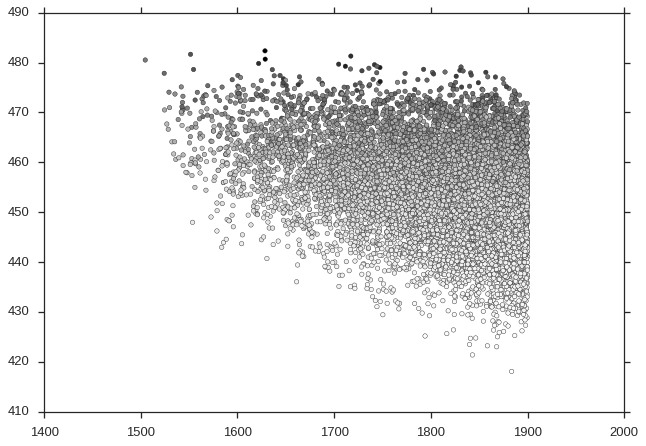

In [7]:
plt.scatter(results[:]['maxDebt'], results[:]['netProfit'], c=results[:]['inventoryTurns'], marker='o')

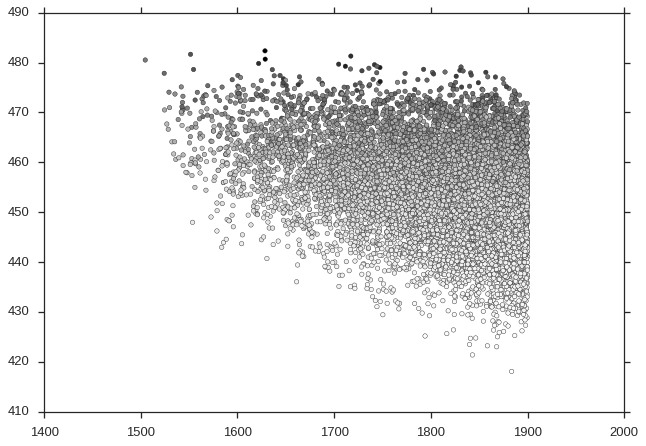

In [15]:
plt.scatter(loaded[:]['maxDebt'], loaded[:]['netProfit'], c=loaded[:]['inventoryTurns'], marker='o')

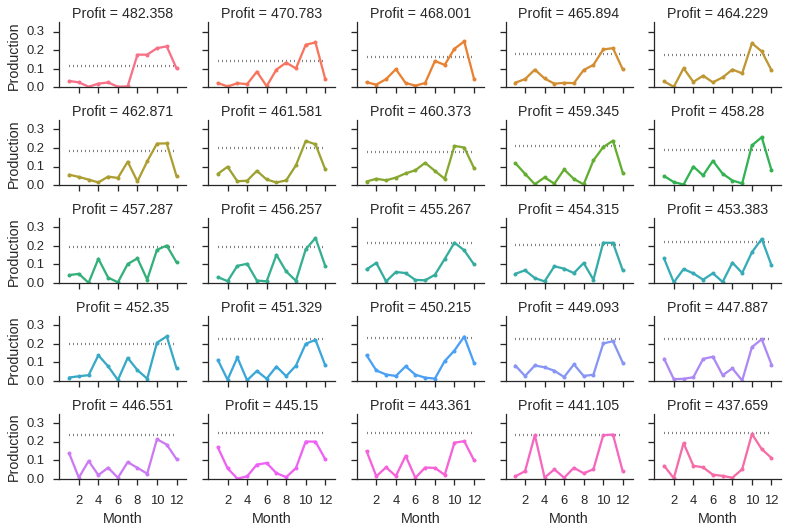

In [30]:
numTrialsToPlot = 25
stride = len(validCases)/numTrialsToPlot
topTrials = np.sort(validCases, order='netProfit')[::-1][::stride]

test = np.c_[np.array([i%12 for i in range(0,12*numTrialsToPlot)])+1, \
             np.concatenate(topTrials['production']), \
             np.concatenate([trials[1,t0:,topTrials[i]['index']]/trials[1,t0:,topTrials[i]['index']].sum() for i in range(numTrialsToPlot)]), \
             np.array([np.floor(i*1.0/12) for i in range(12*numTrialsToPlot)]), \
             np.concatenate([ 12*[np.round(netProfit,3)] for netProfit in topTrials[:]['netProfit']]), \
             np.concatenate([ 12*[np.round(avgI,3)] for avgI in topTrials[:]['avgInventory']]), \
             np.concatenate([ trials[6,t0:,topTrials[i]['index']] for i in range(len(topTrials))]), \
             np.concatenate([ trials[8,t0:,topTrials[i]['index']] for i in range(len(topTrials))]), \
             np.concatenate([ trials[11,t0:,topTrials[i]['index']] for i in range(len(topTrials))]), \
             np.concatenate([ 4*[1, 2, 3] for i in range(len(topTrials)) ])]

testDF = pd.DataFrame(test, columns=['Month', 'Production', 'COGS', 'trial', 'Profit', 'avgI', \
                                     'Cash', 'Inventory', 'Notes Payable', 'Leg'])


# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(testDF, col="Profit", hue="trial", col_wrap=5, size=1.5, aspect=1.5)

#Draw average inventory
grid.map(plt.plot, 'Month', 'avgI', ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "Month", "Production", marker="o", ms=4)

# Adjust the tick positions and labels
grid.set(xticks=range(2,13,2), yticks=[0,0.1,0.2,0.3],xlim=(0, 13), ylim=(0, 0.35))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(pad=1.08)
grid.savefig('Top_By_Profit_Production.png', dpi=100, facecolor='#FFFFFF')

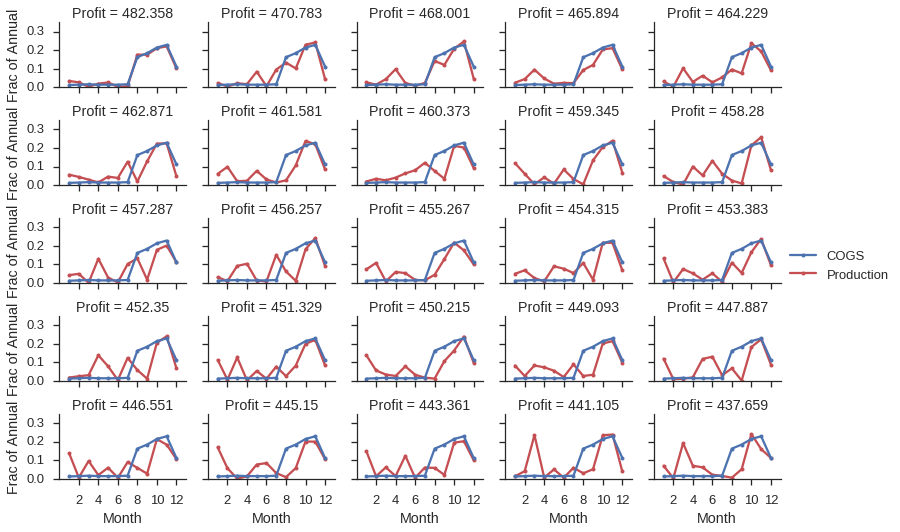

In [35]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(testDF, col="Profit", col_wrap=5, size=1.5, aspect=1.5)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "Month", "Production", marker="o", ms=4, c='r', label='Production')
grid.map(plt.plot, "Month", "COGS", marker="o", ms=4, c='b', label='COGS')
grid.set_ylabels("Frac of Annual")
grid.add_legend()

# Adjust the tick positions and labels
grid.set(xticks=range(2,13,2), yticks=[0,0.1,0.2,0.3],xlim=(0, 13), ylim=(0, 0.35))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(pad=1.08)
grid.savefig('Top_By_Profit_BS.png', dpi=100, facecolor='#FFFFFF')

In [44]:
testDF['Inventory'][0:12].mean()/testDF['avgI'][0:12].mean()

5851.360006480166

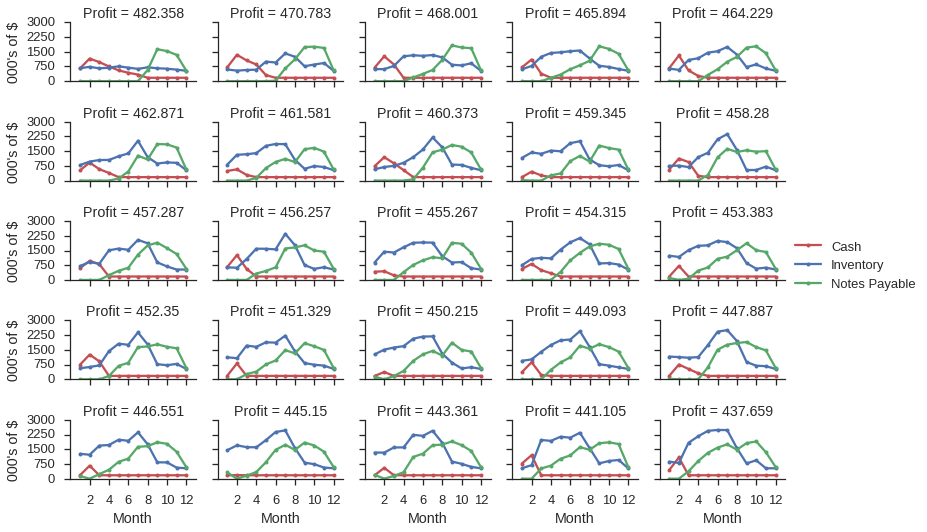

In [48]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(testDF, col="Profit", col_wrap=5, size=1.5, aspect=1.5)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "Month", "Cash", marker="o", ms=4, c='r', label='Cash')
grid.map(plt.plot, "Month", "Inventory", marker="o", ms=4, c='b', label='Inventory')
grid.map(plt.plot, "Month", "Notes Payable", marker="o", ms=4, c='g', label='Notes Payable')
grid.set_ylabels("000's of $")
grid.add_legend()

# Adjust the tick positions and labels
grid.set(xticks=range(2,13,2), yticks=range(0,3001,750), xlim=(0, 13), ylim=(0, 3000))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(pad=1.08)
grid.savefig('Top_By_Profit_BS.png', dpi=100, facecolor='#FFFFFF')

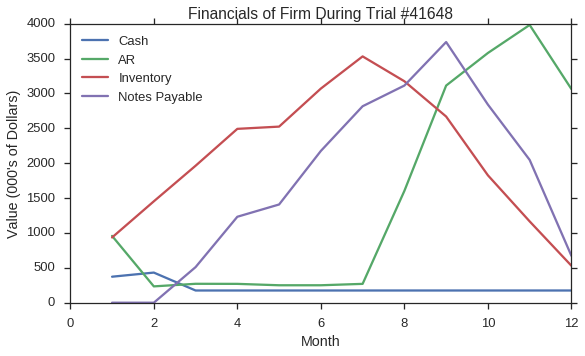

In [451]:
plotTrialData(bestIT, trials, t0)